# Identifying Fraud from Enron Data
### - Marty VanHoof

## Introduction

Founded in 1985, Enron was one of the world's major electricity, natural gas, communications and pulp and paper companies.  Enron was named "America's Most Innovative Company" for six consecutive years by *Fortune* magazine.  Much of this apparent success, though, was due to systematic and elaborate accounting fraud and corruption.  By the use of accounting loopholes, special purpose entities, and poor financial reporting, they were able to hide billions of dollars in debt from failed deals and projects.  By 2002, it had collapsed into bankruptcy, and many executives at Enron would later be indicted and some of them sent to prison.  In the resulting investigation, a large amount of typically confidential information entered into the public record.  This included a large database of emails known as the *Enron Corpus*, and also detailed financial data for top executives.  

The purpose of this project is to try to probe this financial and email data using machine learning techniques in order to attempt to identify persons of interest (POI) in the Enron scandal.  POIs are individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.  This report details the following process:
- [data exploration and outlier removal](#exploration)
- [initial classifier estimation](#initial)
- [feature engineering](#engineering)
- [feature selection](#selection)

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

<a id='exploration'></a>
## Data Exploration / Outlier Removal

We begin by doing some exploratory data analysis (EDA) in order to get a better understanding of the dataset and remove a few outliers.  The Enron email and financial data has been preprocessed and combined into a Python dictionary, where each key-value pair in the dictionary corresponds to one person.  The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. 

In order to make our EDA easier, we will use the Python library Pandas to first transform our Python dictionary into a Pandas dataframe.

In [2]:
# load the dictionary containing the dataset
with open('enron_dataset.pkl', 'rb') as data_file:
    data_dict = pickle.load(data_file)
    
# create a dataframe from data_dict and set the index column to employees
df = pd.DataFrame.from_dict(data_dict, orient='index')

# coerce numeric values into floats and convert NaN values to 0
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
df.fillna(0, inplace=True)

Below are the first 5 rows of our dataset.  The row observations correspond to Enron employees and the columns are the features (the email and financial information for the employee).  There were many missing values in the original financial dataset and these values were encoded in the Python dictionary as 'NaN'.  These NaN values are transformed to 0 in the dataframe.

In [3]:
df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,0.0,4175000.0,0.0,-126027.0,-3081055.0,1729541.0,...,47.0,1729541.0,2195.0,152.0,65.0,False,304805.0,1407.0,126027.0,0.0
BADUM JAMES P,0.0,0.0,178980.0,182466.0,0.0,0.0,0.0,0.0,0.0,257817.0,...,0.0,257817.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,0.0,0.0,0.0,-560222.0,-5104.0,5243487.0,...,39.0,4046157.0,29.0,864523.0,0.0,False,0.0,465.0,1757552.0,0.0
BAXTER JOHN C,267102.0,0.0,1295738.0,5634343.0,0.0,1200000.0,0.0,0.0,-1386055.0,10623258.0,...,0.0,6680544.0,0.0,2660303.0,0.0,False,1586055.0,0.0,3942714.0,0.0
BAY FRANKLIN R,239671.0,0.0,260455.0,827696.0,0.0,400000.0,0.0,-82782.0,-201641.0,63014.0,...,0.0,0.0,0.0,69.0,0.0,False,0.0,0.0,145796.0,0.0


### Some Dataset Characteristics

In [4]:
print('number of data points: ', df.shape[0])
print('number of features: ', df.shape[1])
print('number of POIs: ', df.query('poi == True').shape[0])
print('number of non POIs: ', df.query('poi == False').shape[0])

number of data points:  146
number of features:  21
number of POIs:  18
number of non POIs:  128


Below are the features with missing values (zeros) and the number of missing values for each feature.  We exclude the email addresses since they don't provide useful information and were all converted to zeros in the dataframe.

In [5]:
# print the number of missing values (zeros) for each feature except 'email_address'
zero_counts = (~df.astype(bool)).sum(axis=0)
zero_counts.drop('email_address')

salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
loan_advances                142
bonus                         64
restricted_stock_deferred    128
deferred_income               97
total_stock_value             20
expenses                      51
from_poi_to_this_person       72
exercised_stock_options       44
from_messages                 60
other                         53
from_this_person_to_poi       80
poi                          128
long_term_incentive           80
shared_receipt_with_poi       60
restricted_stock              36
director_fees                129
dtype: int64

### Outliers

Now we will remove a few outliers from the dataset.  Since the dataset is quite small, we should be conservative in removing outliers.  Also, due to the nature of the financial data, outliers such as very larges salaries, bonuses, etc, can be a signal that a particular individual is a POI, so we won't remove any of these (except for the 'TOTAL' row mentioned next). 

Statistically, an outlier is defined to be an observation that is below the first quartile $Q_1$ or above the third quartile $Q_3$ by more than 1.5 times the *interquartile range*, which is $Q_3 - Q_1$.  More specifically, let 

$$ IQR = Q_3 - Q_1 $$

be the interquartile range.  Then any data point $x$ for which

$$ x \leq Q_1 - 1.5 \cdot IQR \quad \textrm{or} \quad x \geq Q_3 + 1.5 \cdot IQR $$

can be considered an outlier.  As mentioned above, outliers of this sort can be indicative of persons of interest so we should be very careful about removing them.  In the code below, we will only look for outliers in the upper range.

In [6]:
# find the individuals with 10 or more outlier features in the upper range
Q1, Q3 = df.quantile(0.25), df.quantile(0.75) 
IQR = Q3 - Q1
outliers = df[df > Q1 + 1.5*IQR]
outlier_counts = outliers.count(axis=1).sort_values(ascending=False).head(7)
outlier_counts = outlier_counts.to_frame(name='outlier_count')
names = list(outlier_counts.index)
outlier_counts['poi'] = df.loc[names].poi
display(outlier_counts)

,outlier_count,poi
LAY KENNETH L,15,True
FREVERT MARK A,14,False
WHALLEY LAWRENCE G,13,False
SKILLING JEFFREY K,13,True
TOTAL,12,False
DELAINEY DAVID W,12,True
LAVORATO JOHN J,10,False


Using this information, we will remove Mark Frevert, Lawrence Whalley, and John Lavorato.  These people are not persons of interest even though they seem to have an unusually high number of outlier features.  

The TOTAL row is also an anomaly.  The Enron financial data comes from a PDF file called [enron61702insiderpay.pdf](enron61702insiderpay.pdf), which contains a row of totals for each financial feature, and this row was read into the Python dictionary (and thus in the dataframe) as an individual observation where it really doesn't belong.  We can get a good view of this outlier from a scatterplot of salaries and bonuses of Enron employees.  This outlier should really be removed because it will throw off our predictions when we try to fit models to the data.

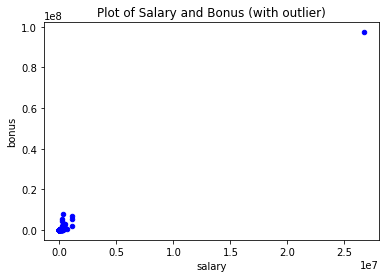

In [7]:
df.plot.scatter(x='salary', y='bonus', color='blue',
                title='Plot of Salary and Bonus (with outlier)');

### Rows containing all zeros

We should also check for observations that contain all zeros, and we can see that this person 'LOCKHART EUGENE E' doesn't have any records.  Finally, if we examine all the names in the dataframe there is one that doesn't seem to belong:  'THE TRAVEL AGENCY IN THE PARK'.  This is probably not a person, so we will remove this observation as well.

In [8]:
display(df.loc[(df == 0).all(axis=1)])
df[df.index.values == 'THE TRAVEL AGENCY IN THE PARK']

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
LOCKHART EUGENE E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0


,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
THE TRAVEL AGENCY IN THE PARK,0.0,0.0,0.0,362096.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,362096.0,0.0,False,0.0,0.0,0.0,0.0


In [9]:
# remove outliers
to_remove = ['FREVERT MARK A', 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G',
             'TOTAL', 'LOCKHART EUGENE E', 'THE TRAVEL AGENCY IN THE PARK']  
df.drop(to_remove, inplace=True)
    
while False:
    to_remove = ['FREVERT MARK A', 'BAXTER JOHN C', 'LAVORATO JOHN J',
                 'WHALLEY LAWRENCE G', 'TOTAL', 'LOCKHART EUGENE E',
                 'THE TRAVEL AGENCY IN THE PARK']
    df.drop(to_remove, inplace=True)
    break

<a id='initial'></a>
## Initial Classifier Estimation

We will start by experimenting with a few different classifiers without worrying about parameter-tuning at this point.  Using the **`test_classifier()`** function in the [tester.py](tester.py) file, we can get an initial idea of the performance of each classifier before we get into tuning the parameters.  We will start by using all the features in the dataset (except email address).  The metrics that we want to optimize are the precision, recall, and the F1 score.

Consider the collection of all people in the Enron dataset who the model predicts to be a POI; then the **precision** is the proportion of those people who are actually POIs.  More precisely, if $TP$ is the number of true positives and $FP$ is the number of false positives, then

$$
\textrm{precision} = \frac{TP}{TP + FP}
$$

Now consider the collection of all people in the Enron dataset who are actually POIs; then the **recall** is the proportion of those individuals who are predicted by the model to be POIs.  If $FN$ is the number of false negatives, then

$$
\textrm{recall} = \frac{TP}{TP + FN}
$$

The **F1 score** is the harmonic mean of precision and recall and can also be interpreted as a weighted average of precision and recall

$$
\textrm{F1 score} = \frac{2}{\frac{1}{\textrm{precision}} + \frac{1}{\textrm{recall}}} = \frac{2 \cdot \textrm{precision} \cdot \textrm{recall}}{\textrm{precision} + \textrm{recall}}
$$

Note that our dataset is imbalanced, since there are 18 POI versus 128 non POI.  This means that the accuracy score (number of accurate predictions divided by the total number of data points) is not a good metric to use.

At this point we should also standardize the data since the financial and email data are measured in different units and on different scales.  We will standardize the data so that it has mean 0 and standard deviation 1. 

In [10]:
from tester import test_classifier
from feature_format import featureFormat, targetFeatureSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# convert the dataframe back into a dictionary
data_dict = df.to_dict('index')

# get a list of all the features and remove 'email_address'
features_list = list(df.columns.values)
features_list.remove('email_address')

# move 'poi' to the beginning of the list for use by the function
# targetFeatureSplit() in feature_format.py
features_list.pop(features_list.index('poi'))
features_list.insert(0, 'poi')

def clf_report(classifier, f_list):
    ''' A quick and dirty function that fits a specific classifier then uses 'test_classifier()'
        to evaluate the model's performance '''
    
    # Extract features and labels from data_dict
    data_array = featureFormat(data_dict, f_list, sort_keys = True)
    labels, features = targetFeatureSplit(data_array)
    
    # Apply feature scaling
    features = scale(features)

    # Split features and labels into training and testing sets
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
    
    clf = classifier()
    clf.fit(features_train, labels_train)
    test_classifier(clf, data_dict, f_list)

### GaussianNB

In [11]:
clf_report(GaussianNB, features_list)

Accuracy: 0.75721	Precision: 0.25186	Recall: 0.35500	F1: 0.29467	F2: 0.32813
Total predictions: 14000	True positives:  710	False positives: 2109
False negatives: 1290	True negatives: 9891



### DecisionTreeClassifier

In [12]:
clf_report(DecisionTreeClassifier, features_list)

Accuracy: 0.82250	Precision: 0.36007	Recall: 0.31200	F1: 0.33432	F2: 0.32056
Total predictions: 14000	True positives:  624	False positives: 1109
False negatives: 1376	True negatives: 10891



### LogisticRegression

In [13]:
clf_report(LogisticRegression, features_list)

Accuracy: 0.78636	Precision: 0.21572	Recall: 0.18800	F1: 0.20091	F2: 0.19296
Total predictions: 14000	True positives:  376	False positives: 1367
False negatives: 1624	True negatives: 10633



### KNeighborsClassifier

In [14]:
clf_report(KNeighborsClassifier, features_list)

Accuracy: 0.87693	Precision: 0.70102	Recall: 0.24150	F1: 0.35924	F2: 0.27794
Total predictions: 14000	True positives:  483	False positives:  206
False negatives: 1517	True negatives: 11794



<a id='engineering'></a>
## Feature Engineering

The first two features we will create are called **fraction_of_emails_to_poi** and **fraction_of_emails_from_poi**.  The hypothesis here is that persons of interest may have stronger email connections between each other, ie. that POIs send emails to other POIs at a higher rate than for the general population.  The feature **fraction_of_emails_to_poi** is the proportion of all messages from a particular person that are sent to a poi, and the feature **fraction_of_emails_from_poi** is the proportion of all messages to a particular person that are sent from a poi.

If we plot the features with POI in red and non POI in blue, then there appears to be some clustering in the POIs.  Specifically, if the proportion of an individual's emails from/to a poi are below a certain threshold, then we can be confident that this individual is not a poi (the converse is not true, however).  This suggests that the above hypothesis has some merit, and we will see that these two new features will improve algorithm performance.

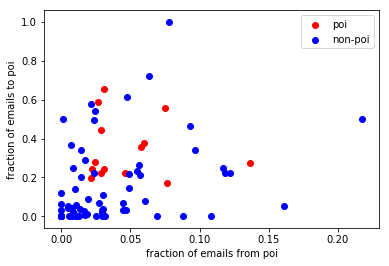

In [48]:
# create the two new features mentioned above
df['fraction_of_emails_to_poi'] = df.from_this_person_to_poi / df.from_messages
df['fraction_of_emails_from_poi'] = df.from_poi_to_this_person / df.to_messages

# split the data into poi and non-poi
df_poi = df.query('poi == True')
df_nonpoi = df.query('poi == False')

# plot the new features
plt.scatter(df_poi.fraction_of_emails_from_poi, df_poi.fraction_of_emails_to_poi,
            color='red', label='poi')
plt.scatter(df_nonpoi.fraction_of_emails_from_poi, df_nonpoi.fraction_of_emails_to_poi,
            color='blue', label='non-poi')
plt.xlabel('fraction of emails from poi')
plt.ylabel('fraction of emails to poi')
plt.legend();